# Import libraries, read data from SQL database, create dataframe

In [2]:
import pyodbc  # module for accessing ODBC databases
import pandas as pd #pandas library
import numpy as np #numpy library
import matplotlib.pyplot as plt # matplotlib library
import warnings
import seaborn as sns #seaborn library

# connection data of SQL server and database
driver = 'DRIVER={SQL Server}'  # for MS SQL (driver is different for MySQL etc.)
server = 'xxxxxxxxxxxxxxxxxxxxxx.windows.net' 
database = 'xxxxxxx' 
username = 'xxxxxxx' 
password = 'xxxxxxx'  

# connect
cnxn = pyodbc.connect(driver + ';SERVER=' + server + ';DATABASE=' + database + ';UID=' + username + ';PWD=' + password)

# SQL query to pre-filter data
query = 'select c.Country, c.City, od.OrderID, od.OrderQty, od.LineTotal, o.OrderDate, o.SalesPersonID, \
p.Name, p.Color, p.Style, p.Class \
from Orders o \
join Customer c on o.CustomerID = c.CustomerID \
join OrderDetail od on od.OrderID = o.OrderID \
join Product p on p.ProductID = od.ProductID;'

#ignore warnings
warnings.filterwarnings('ignore')

# read the data from the SQL database based on the query
df = pd.read_sql(query, cnxn)


In [3]:
df

,Country,City,OrderID,OrderQty,LineTotal,OrderDate,SalesPersonID,Name,Color,Style,Class
0,None,None,43659,1,2024.994,2011-05-31,279.0,"Mountain-100 Black, 42",Black,U,H
1,None,None,43659,3,6074.982,2011-05-31,279.0,"Mountain-100 Black, 44",Black,U,H
2,None,None,43659,1,2024.994,2011-05-31,279.0,"Mountain-100 Black, 48",Black,U,H
3,None,None,43659,1,2039.994,2011-05-31,279.0,"Mountain-100 Silver, 38",Silver,U,H
4,None,None,43659,1,2039.994,2011-05-31,279.0,"Mountain-100 Silver, 42",Silver,U,H
...,...,...,...,...,...,...,...,...,...,...,...
121312,CA,Sooke,75122,1,21.980,2014-06-30,NaN,Fender Set - Mountain,None,None,None
121313,CA,Sooke,75122,1,8.990,2014-06-30,NaN,AWC Logo Cap,Multi,U,None
121314,CA,Sooke,75123,1,21.980,2014-06-30,NaN,Fender Set - Mountain,None,None,None
121315,CA,Sooke,75123,1,159.000,2014-06-30,NaN,All-Purpose Bike Stand,None,None,None


# Data clean and prepare

In [4]:
# remove spaces
df['Class'] = df['Class'].str.replace('\s+', '', regex = True)

# convert OrderDate column's data type to datetime
df['OrderDate'] = df['OrderDate'].astype('datetime64')

# # Convert the LineTotal column to FLOAT data type_prepare
df['LineTotal'] = df['LineTotal'].astype(str).str.replace(',', '.')

# # Convert the LineTotal column to FLOAT data type
df['LineTotal'] = pd.to_numeric(df['LineTotal'], errors = 'coerce')
df['LineTotal'] = df['LineTotal'].astype(dtype = 'float64', errors = 'ignore')

# split original ProductName to ProductName and Size (separated by a comma&space)
df[ ['ProductName', 'Size'] ] = df['Name'].str.split(', ', expand = True)

# remove Class 'Name'
df = df.drop(['Name'], axis = 1)

# if the Size column shows “Black”, “Red” or “Blue”, replace to “-“
df['Size'] = df['Size'].str.replace('Black', "-")
df['Size'] = df['Size'].str.replace('Red', '-')
df['Size'] = df['Size'].str.replace('Blue', '-')

# export to Excel file for the excel-addicted collegaues :-)
# df.to_excel(r'C:\Dokumentumok\salesdata.xlsx', index = False, sheet_name = 'Sheet1') 


In [5]:
df

,Country,City,OrderID,OrderQty,LineTotal,OrderDate,SalesPersonID,Color,Style,Class,ProductName,Size
0,None,None,43659,1,2024.994,2011-05-31,279.0,Black,U,H,Mountain-100 Black,42
1,None,None,43659,3,6074.982,2011-05-31,279.0,Black,U,H,Mountain-100 Black,44
2,None,None,43659,1,2024.994,2011-05-31,279.0,Black,U,H,Mountain-100 Black,48
3,None,None,43659,1,2039.994,2011-05-31,279.0,Silver,U,H,Mountain-100 Silver,38
4,None,None,43659,1,2039.994,2011-05-31,279.0,Silver,U,H,Mountain-100 Silver,42
...,...,...,...,...,...,...,...,...,...,...,...,...
121312,CA,Sooke,75122,1,21.980,2014-06-30,NaN,None,None,None,Fender Set - Mountain,None
121313,CA,Sooke,75122,1,8.990,2014-06-30,NaN,Multi,U,None,AWC Logo Cap,None
121314,CA,Sooke,75123,1,21.980,2014-06-30,NaN,None,None,None,Fender Set - Mountain,None
121315,CA,Sooke,75123,1,159.000,2014-06-30,NaN,None,None,None,All-Purpose Bike Stand,None


# Plotting charts

In [6]:
# prepare data
daily_revenue = df.groupby("OrderDate").agg({"LineTotal":"sum"})
monthly_revenue = daily_revenue.resample("M").sum()

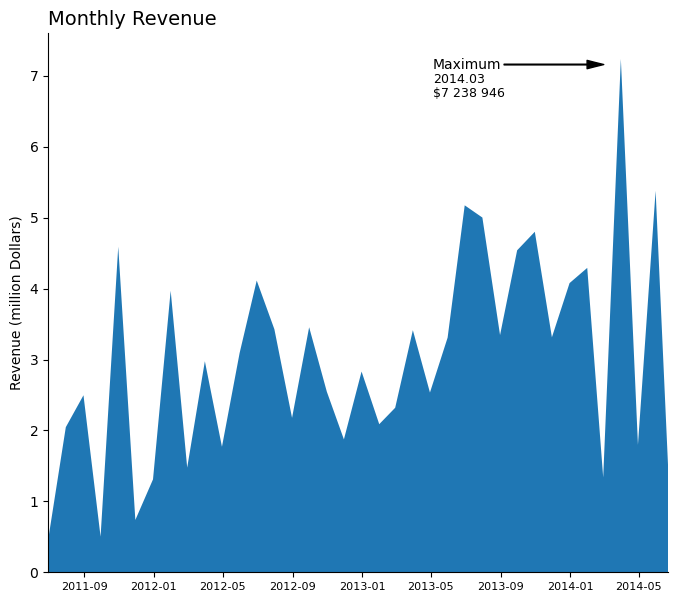

In [7]:
fig, ax = plt.subplots(figsize=(8, 7))

ax.stackplot(
    monthly_revenue.index, 
    monthly_revenue["LineTotal"]/1000000, 
    linewidth=3
)

ax.set_title("Monthly Revenue", fontsize=14, loc="left")
ax.set_ylabel("Revenue (million Dollars)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(15155, 16243)

plt.yticks(fontsize=10)
plt.xticks(fontsize=8)

ax.annotate("Maximum",
            xy=(16130, 7.16),
            xytext=(15830, 7.16),
            arrowprops=dict(
                facecolor="black", 
                width=.5, 
                headwidth=6,
                connectionstyle="angle3, angleA=290, angleB=0"
            ),
            verticalalignment="center"
)

ax.text(15830, 6.9, 
         "2014.03" ,
         fontsize=9
)

ax.text(15830, 6.70, 
         "$7 238 946" ,
         fontsize=9
)
        
plt.show()

In [8]:
# prepare data
country_revenue = (df.query("Country in ['US', 'GB', 'FR']"))

In [9]:
country_revenue_pivot = (
    country_revenue 
    .set_index("OrderDate")
    .loc[:, ["Country", "LineTotal"]]
    .sort_index()
    .pivot_table(
        index="OrderDate",
        columns="Country",
        values="LineTotal"
    )
   .resample("M")
   .mean()
)

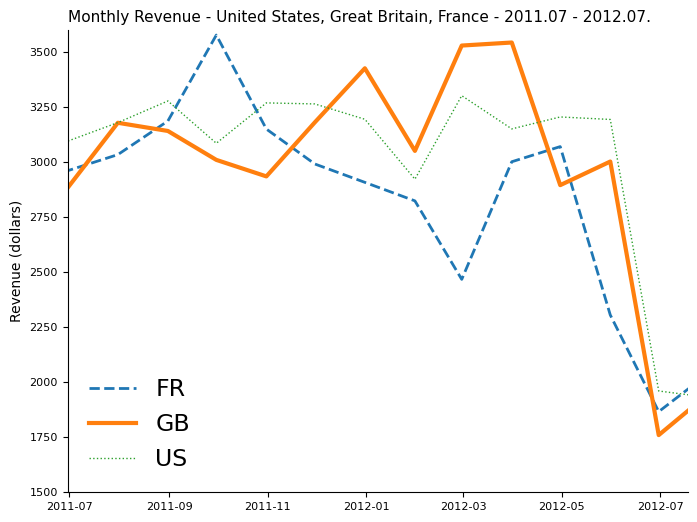

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    country_revenue_pivot.index, 
    country_revenue_pivot["FR"], 
    linewidth=2,
    ls="--"
    
)

ax.plot(
    country_revenue_pivot.index, 
    country_revenue_pivot["GB"], 
    linewidth=3
)

ax.plot(
    country_revenue_pivot.index, 
    country_revenue_pivot["US"], 
    linewidth=1,
    ls=":"
)

ax.set_title("Monthly Revenue - United States, Great Britain, France - 2011.07 - 2012.07.", fontsize=11, loc="left")
ax.set_ylabel("Revenue (dollars)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(15155, 15539)
ax.set_ylim(1500, 3600)
ax.legend(country_revenue_pivot.columns, loc="lower left", fontsize=17, frameon=False)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
        
plt.show()

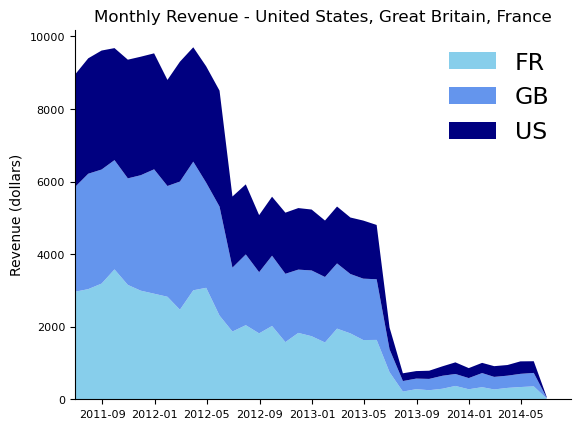

In [11]:
fig, ax = plt.subplots()

ax.stackplot(
    country_revenue_pivot.index, 
    country_revenue_pivot["FR"], 
    country_revenue_pivot["GB"],
    country_revenue_pivot["US"],
    colors=["skyblue", "cornflowerblue", "navy"],
)



ax.set_title("Monthly Revenue - United States, Great Britain, France")
ax.set_ylabel("Revenue (dollars)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(15155, )

ax.legend(country_revenue_pivot.columns, loc="upper right", fontsize=17, frameon=False)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
        
plt.show()

In [12]:
#prepare data
sales_totals = (
    df
    .query("Class in ['H', 'L', 'M']")
    .groupby("Class")
    .agg({"LineTotal":"sum"})
)

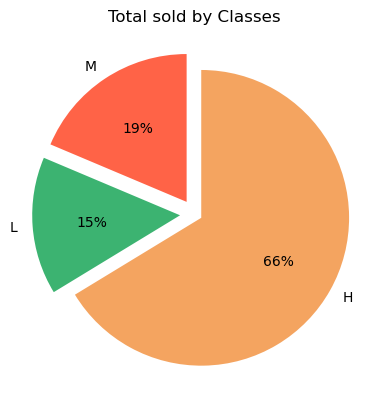

In [13]:
fig, ax = plt.subplots()

ax.pie(x=sales_totals["LineTotal"][::-1],
       startangle=90,
       labels=["M", "L", "H",], 
       colors=["tomato", "mediumseagreen", "sandybrown"],
       autopct="%.0f%%",
       explode=(.1, .1, .05)
      )

ax.set_title("Total sold by Classes")

plt.show()

In [14]:
#prepare data
total_sold = (df
 .groupby("Color")
 .agg({"LineTotal":"sum"})
 .sort_values("LineTotal", ascending=False)
 .iloc[:10])

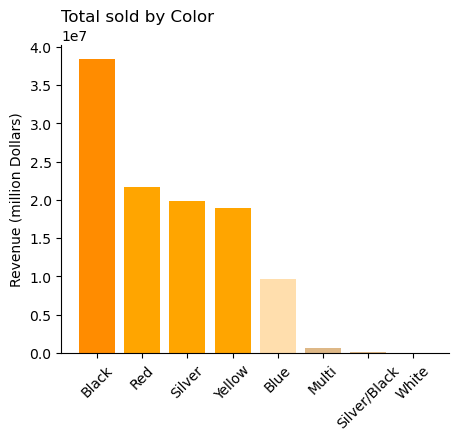

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))

colors = [
    "darkorange", 
    "orange",
    "orange",
    "orange",
    "navajowhite",
    "burlywood",
    "burlywood",
    "burlywood"
]

ax.bar(x=total_sold.index, 
       height=total_sold["LineTotal"],
       color=colors
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Revenue (million Dollars)")
ax.set_title("Total sold by Color", loc="left")
ax.xaxis.set_tick_params(rotation=45)

plt.show()

In [16]:
#prepare data
ca_or = (df
         .loc[df["Class"].str[-2:].isin(["H", "L", "M"])]
     
         .assign(price_range = pd.cut(
                    df.loc[:,"LineTotal"],
                    [0, 400000, 600000, 2000000],
                    labels=["0-400k", "400k-600k","600k+"]),
                state = lambda x: x["Class"].str[-2:]
         
        ).query("OrderDate > '2012-12-01' and OrderDate < '2012-12-31'")
         .pivot_table(
             index="OrderDate",
             columns="Class",
             values="LineTotal",
            aggfunc="sum"
         )       
)

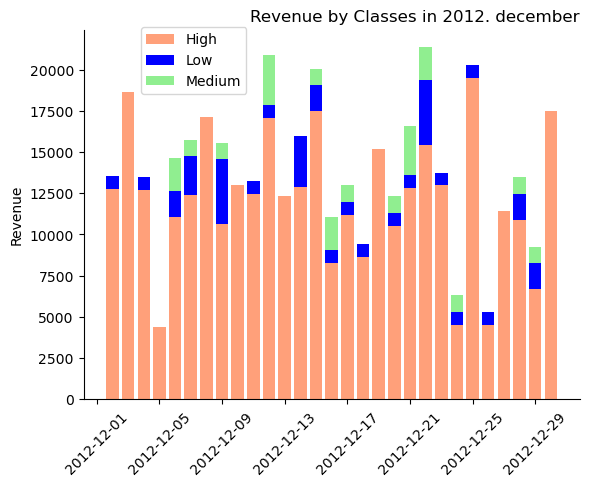

In [17]:
fig, ax = plt.subplots()

ax.bar(
    ca_or.index, 
    ca_or["H"], 
    label="High",
    color="lightsalmon"
)

ax.bar(
    ca_or.index, 
    ca_or["L"], 
    label="Low", 
    bottom=ca_or["H"],
    color="blue"
)


ax.bar(
    ca_or.index, 
    ca_or["M"], 
    label="Medium", 
    bottom=ca_or["H"] + ca_or["L"],
    color="lightgreen"
)

ax.set_title("Revenue by Classes in 2012. december", loc="right")
ax.set_ylabel("Revenue")
ax.xaxis.set_tick_params(rotation=45)

fig.legend(bbox_to_anchor=(.39, .9))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

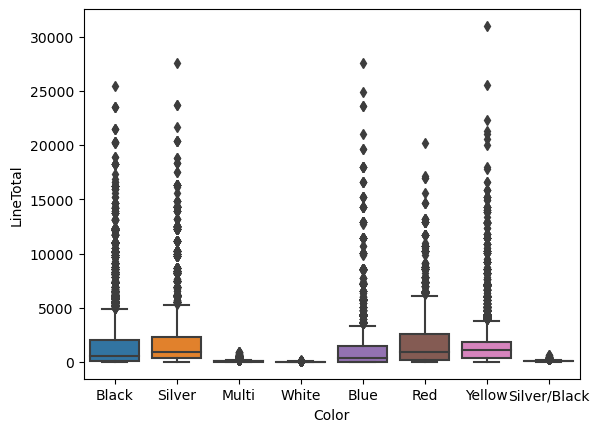

In [18]:
sns.boxplot(x="Color", y="LineTotal", data=df)

plt.show()